# Prophet Application for Water Demand Forecase (YeoSu)

## 1. Load Required Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
# import folium
# from folium.plugins import MarkerCluster
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import skew
import sys
from glob import glob 
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import holidays
#sys.path.append('code/')
import utils
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )
%matplotlib inline

np.random.seed(42)

In [2]:

city_name = "GoYang-City"
# city_name = "GwaCheon-City"
# city_name = "GwangYang-City"
# city_name = "GwangJu-City"
# city_name = "NonSan-City"
# city_name = "DaeJeon-City"
# city_name = "EumSeong-Gun"
# city_name = "JangSu-Gun"
# city_name = "HwaSeong-City"
# city_name = "HoengSeong-Gun"

In [3]:
city_data = "1_goyang_city.xlsx"
# city_data = "2_gwacheon_city.xlsx"
# city_data = "3_gwangyang_city.xlsx"
# city_data = "4_gwangju_city.xlsx"
# city_data = "5_nonsan_city.xlsx"
# city_data = "6_daejeon_city.xlsx"
# city_data = "8_eumseong_gun.xlsx"
# city_data = "9_jangsu_gun.xlsx"
# city_data = "10_hwaseong_city.xlsx"
# city_data = "11_hoengseong_gun.xlsx"

In [4]:
# Read excel file using pandas
df = pd.read_excel(open(f"./data/{city_data}", 'rb'), sheet_name="training", header=4, index_col=0)
# Remove unnecessary columns for this analysis
total_data_df = df.iloc[2:]
# Change Date Format and Set Date as index
total_data_df.index = pd.to_datetime(total_data_df.index.str.strip(), format='%Y-%m')
total_data_df.index.name = "date"
# Change data format from "Object" to "Float"
total_data_df["water_supply"] = total_data_df.water_supply.astype(float)
total_data_df["Total_Population"] = total_data_df.Total_Population.astype(float)
# Delete unnecessary columns 
total_data_df.drop(columns=total_data_df.columns[19:21], inplace=True)
total_data_df.drop(columns=total_data_df.columns[22:23], inplace=True)
# Select clean data
total_data_df = total_data_df.loc["2011-01-01":]
total_data_df

/tmp/ipykernel_707/2442152005.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data_df["water_supply"] = total_data_df.water_supply.astype(float)
/tmp/ipykernel_707/2442152005.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data_df["Total_Population"] = total_data_df.Total_Population.astype(float)
/tmp/ipykernel_707/2442152005.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

,water_supply,Total_Population,Households,Population_per_Households,Male_Population,Female_Population,Male_Female_Ratio,Population_aging_Ratio,Power_usage,Num_of_Business,...,personal_expense,benefits_vs_personal_expense,employment_ratio,employment_insurance_ratio,Average_Temp,Monthly_Rainfall,Average_Relative_Humadity,Ground_Temp,Average_Wind,Average_Pressure
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,290220.193548,950815.0,360163.0,2.639957,469910.0,480905.0,0.977137,0.090,460456000.0,23212.0,...,110568031.0,0.227,104214.0,0.109605,-7.2,8.9,0.54,-4.7,2.8,1016.1
2011-02-01,288217.928571,952732.0,360854.0,2.640215,470828.0,481904.0,0.977016,0.090,438973000.0,21515.0,...,110568031.0,0.227,103279.0,0.108403,1.2,29.1,0.55,1.7,2.6,1011.3
2011-03-01,282349.064516,953983.0,360940.0,2.643051,471442.0,482541.0,0.976999,0.090,372082000.0,22169.0,...,110568031.0,0.227,105191.0,0.110265,3.6,14.6,0.51,6.4,3.4,1010.7
2011-04-01,288019.966667,955128.0,361177.0,2.644487,471862.0,483266.0,0.976402,0.090,359714000.0,22004.0,...,110568031.0,0.227,106496.0,0.111499,10.7,110.1,0.54,13.6,3.2,1003.8
2011-05-01,299486.322581,956268.0,361434.0,2.645761,472378.0,483890.0,0.976209,0.091,319599000.0,22972.0,...,110568031.0,0.227,107280.0,0.112186,17.9,53.4,0.57,21.0,2.8,1000.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,354382.451613,1080896.0,454793.0,2.376677,528972.0,551924.0,0.958415,0.140,487867544.0,46416.0,...,218316665.0,0.293,171845.0,0.158984,25.9,211.2,0.74,28.2,2.1,998.6
2021-09-01,343537.800000,1080787.0,455501.0,2.372743,528911.0,551876.0,0.958387,0.141,401433572.0,45514.0,...,218316665.0,0.293,172771.0,0.159857,22.6,131.0,0.71,24.6,2.3,1003.4
2021-10-01,340126.806452,1080240.0,455845.0,2.369753,528683.0,551557.0,0.958528,0.142,358286760.0,45839.0,...,218316665.0,0.293,173486.0,0.160599,15.6,57.0,0.70,16.7,2.1,1011.0


## 2. Load Data

### 2.1 Load Past Predictor (Independent) Variables

In [5]:
total_data_df.columns[0]

'water_supply'

In [6]:
total_data_df["ds"] = total_data_df.index
total_data_df["y"] = total_data_df[total_data_df.columns[0]].values

In [7]:
total_data_df

,water_supply,Total_Population,Households,Population_per_Households,Male_Population,Female_Population,Male_Female_Ratio,Population_aging_Ratio,Power_usage,Num_of_Business,...,employment_ratio,employment_insurance_ratio,Average_Temp,Monthly_Rainfall,Average_Relative_Humadity,Ground_Temp,Average_Wind,Average_Pressure,ds,y
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,290220.193548,950815.0,360163.0,2.639957,469910.0,480905.0,0.977137,0.090,460456000.0,23212.0,...,104214.0,0.109605,-7.2,8.9,0.54,-4.7,2.8,1016.1,2011-01-01,290220.193548
2011-02-01,288217.928571,952732.0,360854.0,2.640215,470828.0,481904.0,0.977016,0.090,438973000.0,21515.0,...,103279.0,0.108403,1.2,29.1,0.55,1.7,2.6,1011.3,2011-02-01,288217.928571
2011-03-01,282349.064516,953983.0,360940.0,2.643051,471442.0,482541.0,0.976999,0.090,372082000.0,22169.0,...,105191.0,0.110265,3.6,14.6,0.51,6.4,3.4,1010.7,2011-03-01,282349.064516
2011-04-01,288019.966667,955128.0,361177.0,2.644487,471862.0,483266.0,0.976402,0.090,359714000.0,22004.0,...,106496.0,0.111499,10.7,110.1,0.54,13.6,3.2,1003.8,2011-04-01,288019.966667
2011-05-01,299486.322581,956268.0,361434.0,2.645761,472378.0,483890.0,0.976209,0.091,319599000.0,22972.0,...,107280.0,0.112186,17.9,53.4,0.57,21.0,2.8,1000.8,2011-05-01,299486.322581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,354382.451613,1080896.0,454793.0,2.376677,528972.0,551924.0,0.958415,0.140,487867544.0,46416.0,...,171845.0,0.158984,25.9,211.2,0.74,28.2,2.1,998.6,2021-08-01,354382.451613
2021-09-01,343537.800000,1080787.0,455501.0,2.372743,528911.0,551876.0,0.958387,0.141,401433572.0,45514.0,...,172771.0,0.159857,22.6,131.0,0.71,24.6,2.3,1003.4,2021-09-01,343537.800000
2021-10-01,340126.806452,1080240.0,455845.0,2.369753,528683.0,551557.0,0.958528,0.142,358286760.0,45839.0,...,173486.0,0.160599,15.6,57.0,0.70,16.7,2.1,1011.0,2021-10-01,340126.806452


## 3. Application of Prophet

### 3.1 Fit Prophet Model

In [8]:
import itertools

In [9]:
selected_cols = ['ds', 'y']
total_data_df['ds'] = total_data_df.index

In [10]:
total_data_df

,water_supply,Total_Population,Households,Population_per_Households,Male_Population,Female_Population,Male_Female_Ratio,Population_aging_Ratio,Power_usage,Num_of_Business,...,employment_ratio,employment_insurance_ratio,Average_Temp,Monthly_Rainfall,Average_Relative_Humadity,Ground_Temp,Average_Wind,Average_Pressure,ds,y
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,290220.193548,950815.0,360163.0,2.639957,469910.0,480905.0,0.977137,0.090,460456000.0,23212.0,...,104214.0,0.109605,-7.2,8.9,0.54,-4.7,2.8,1016.1,2011-01-01,290220.193548
2011-02-01,288217.928571,952732.0,360854.0,2.640215,470828.0,481904.0,0.977016,0.090,438973000.0,21515.0,...,103279.0,0.108403,1.2,29.1,0.55,1.7,2.6,1011.3,2011-02-01,288217.928571
2011-03-01,282349.064516,953983.0,360940.0,2.643051,471442.0,482541.0,0.976999,0.090,372082000.0,22169.0,...,105191.0,0.110265,3.6,14.6,0.51,6.4,3.4,1010.7,2011-03-01,282349.064516
2011-04-01,288019.966667,955128.0,361177.0,2.644487,471862.0,483266.0,0.976402,0.090,359714000.0,22004.0,...,106496.0,0.111499,10.7,110.1,0.54,13.6,3.2,1003.8,2011-04-01,288019.966667
2011-05-01,299486.322581,956268.0,361434.0,2.645761,472378.0,483890.0,0.976209,0.091,319599000.0,22972.0,...,107280.0,0.112186,17.9,53.4,0.57,21.0,2.8,1000.8,2011-05-01,299486.322581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,354382.451613,1080896.0,454793.0,2.376677,528972.0,551924.0,0.958415,0.140,487867544.0,46416.0,...,171845.0,0.158984,25.9,211.2,0.74,28.2,2.1,998.6,2021-08-01,354382.451613
2021-09-01,343537.800000,1080787.0,455501.0,2.372743,528911.0,551876.0,0.958387,0.141,401433572.0,45514.0,...,172771.0,0.159857,22.6,131.0,0.71,24.6,2.3,1003.4,2021-09-01,343537.800000
2021-10-01,340126.806452,1080240.0,455845.0,2.369753,528683.0,551557.0,0.958528,0.142,358286760.0,45839.0,...,173486.0,0.160599,15.6,57.0,0.70,16.7,2.1,1011.0,2021-10-01,340126.806452


In [11]:
analysis_datasets = total_data_df[selected_cols].loc["2010-01-01":"2021-12-01"]
forecast_datasets = total_data_df[selected_cols].loc["2010-01-01":"2018-12-01"]

In [12]:
total_data_df.loc

In [13]:
analysis_datasets

,ds,y
date,,
2011-01-01,2011-01-01,290220.193548
2011-02-01,2011-02-01,288217.928571
2011-03-01,2011-03-01,282349.064516
2011-04-01,2011-04-01,288019.966667
2011-05-01,2011-05-01,299486.322581
...,...,...
2021-08-01,2021-08-01,354382.451613
2021-09-01,2021-09-01,343537.800000
2021-10-01,2021-10-01,340126.806452


In [14]:
forecast_datasets

,ds,y
date,,
2011-01-01,2011-01-01,290220.193548
2011-02-01,2011-02-01,288217.928571
2011-03-01,2011-03-01,282349.064516
2011-04-01,2011-04-01,288019.966667
2011-05-01,2011-05-01,299486.322581
...,...,...
2018-08-01,2018-08-01,366982.483871
2018-09-01,2018-09-01,334061.000000
2018-10-01,2018-10-01,334383.064516


In [15]:
from datetime import datetime

In [16]:
forecast_datasets['ds']

date
2011-01-01   2011-01-01
2011-02-01   2011-02-01
2011-03-01   2011-03-01
2011-04-01   2011-04-01
2011-05-01   2011-05-01
                ...    
2018-08-01   2018-08-01
2018-09-01   2018-09-01
2018-10-01   2018-10-01
2018-11-01   2018-11-01
2018-12-01   2018-12-01
Name: ds, Length: 96, dtype: datetime64[ns]

In [17]:
forecast_datasets

,ds,y
date,,
2011-01-01,2011-01-01,290220.193548
2011-02-01,2011-02-01,288217.928571
2011-03-01,2011-03-01,282349.064516
2011-04-01,2011-04-01,288019.966667
2011-05-01,2011-05-01,299486.322581
...,...,...
2018-08-01,2018-08-01,366982.483871
2018-09-01,2018-09-01,334061.000000
2018-10-01,2018-10-01,334383.064516


10:42:00 - cmdstanpy - INFO - Chain [1] start processing


10:42:00 - cmdstanpy - INFO - Chain [1] done processing
10:42:00 - cmdstanpy - INFO - Chain [1] start processing
10:42:00 - cmdstanpy - INFO - Chain [1] done processing
10:42:01 - cmdstanpy - INFO - Chain [1] start processing
10:42:01 - cmdstanpy - INFO - Chain [1] done processing
10:42:01 - cmdstanpy - INFO - Chain [1] start processing
10:42:01 - cmdstanpy - INFO - Chain [1] done processing
10:42:01 - cmdstanpy - INFO - Chain [1] start processing
10:42:01 - cmdstanpy - INFO - Chain [1] done processing
10:42:02 - cmdstanpy - INFO - Chain [1] start processing
10:42:02 - cmdstanpy - INFO - Chain [1] done processing
10:42:02 - cmdstanpy - INFO - Chain [1] start processing
10:42:02 - cmdstanpy - INFO - Chain [1] done processing
10:42:02 - cmdstanpy - INFO - Chain [1] start processing
10:42:02 - cmdstanpy - INFO - Chain [1] done processing
10:42:03 - cmdstanpy - INFO - Chain [1] start processing
10:42:03 - cmdstanpy - INFO - Chain [1] done processing
10:42:03 - cmdstanpy - INFO - Chain [1] 

    changepoint_prior_scale  seasonality_prior_scale        r2           mae  \
0                     0.001                     0.01  0.584195   5996.219452   
1                     0.001                     0.10  0.580522   6237.846497   
2                     0.001                     1.00  0.580375   6095.829190   
3                     0.001                    10.00  0.584704   6045.311988   
4                     0.010                     0.01  0.018198  11308.833088   
5                     0.010                     0.10  0.019350  11086.246187   
6                     0.010                     1.00  0.046311  10881.418866   
7                     0.010                    10.00  0.019699  11023.844653   
8                     0.100                     0.01 -2.709595  21659.917191   
9                     0.100                     0.10 -2.708161  21640.497126   
10                    0.100                     1.00 -2.765770  21823.507705   
11                    0.100             

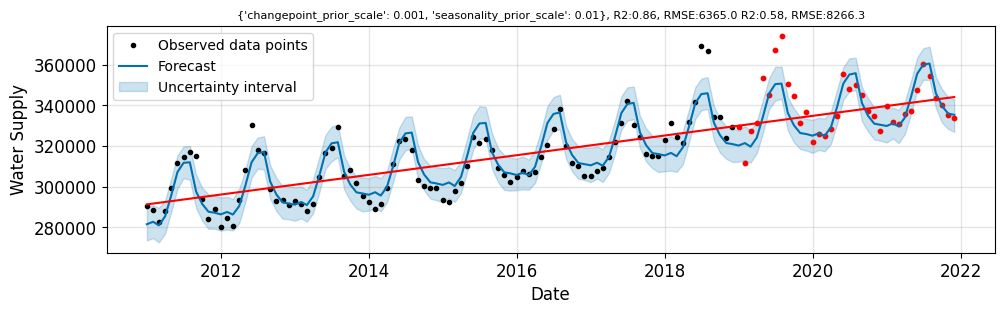

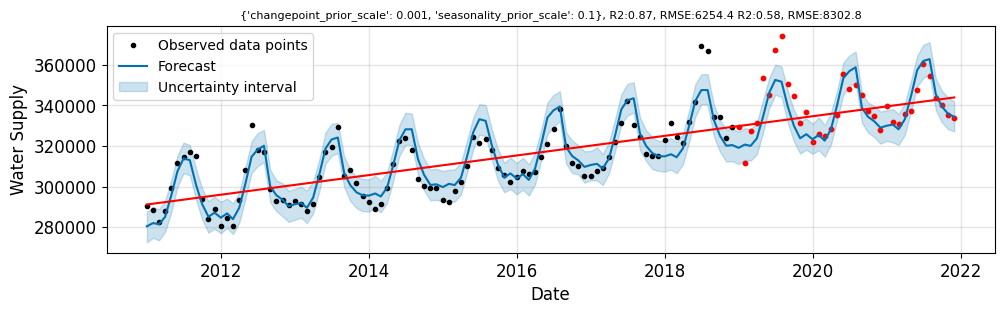

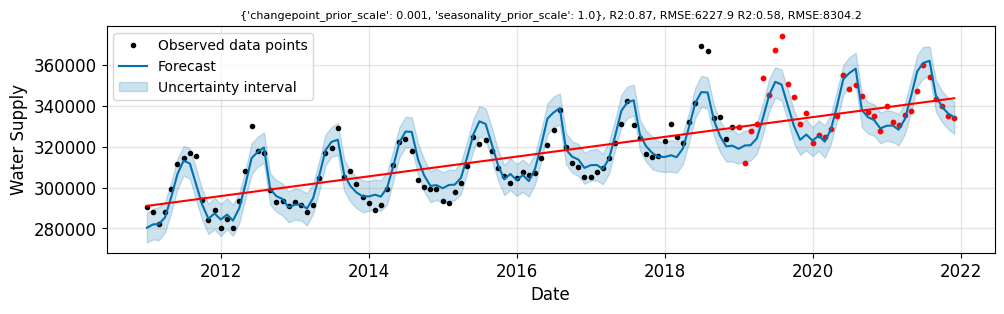

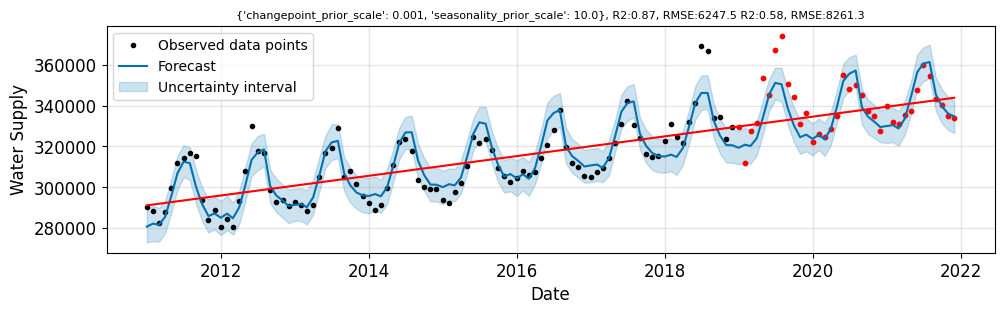

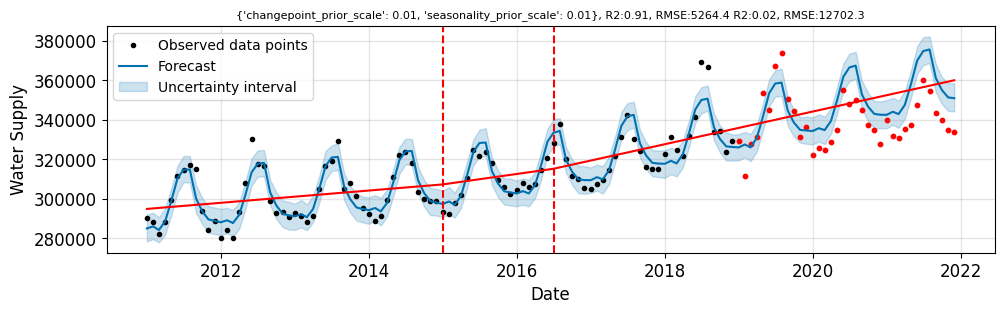

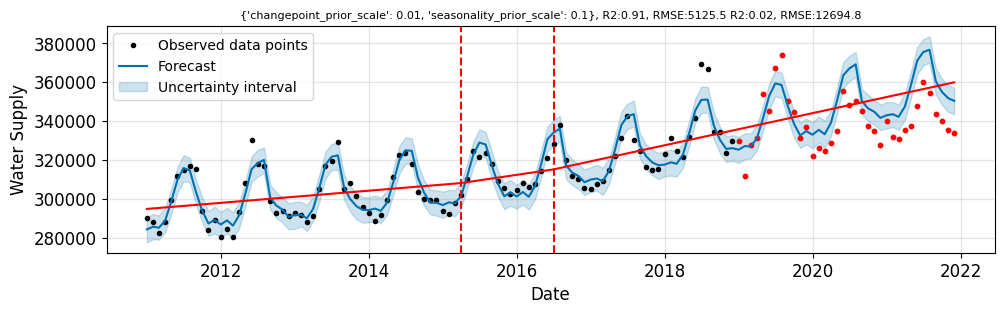

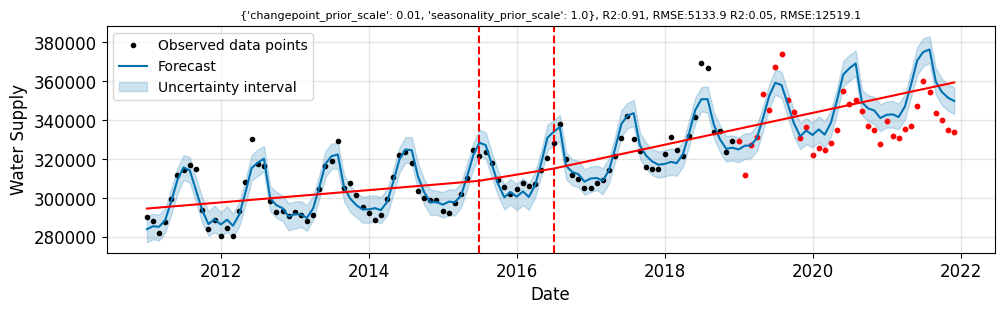

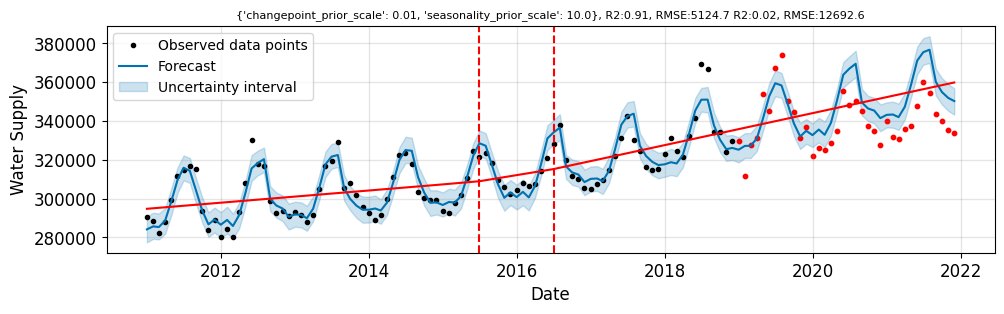

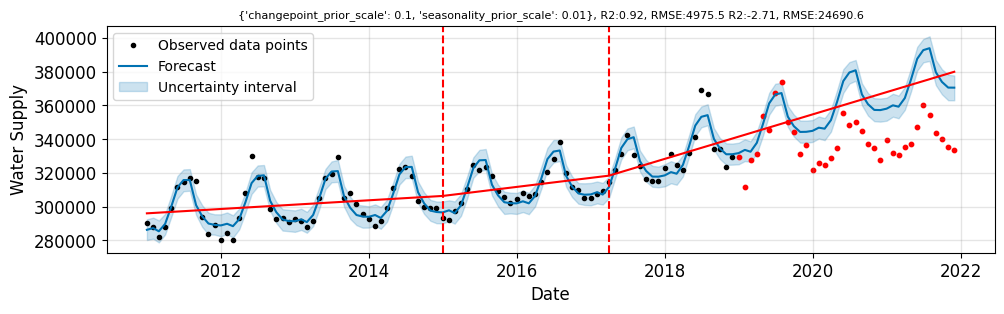

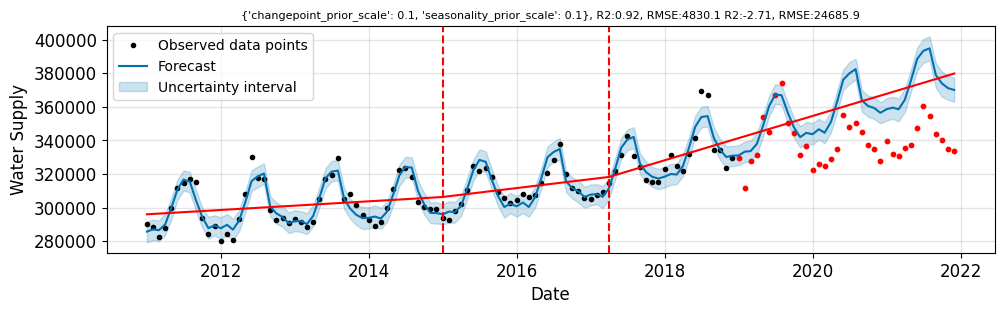

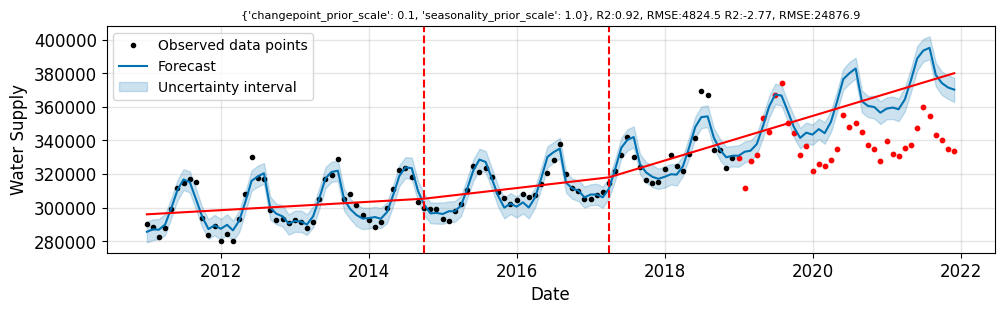

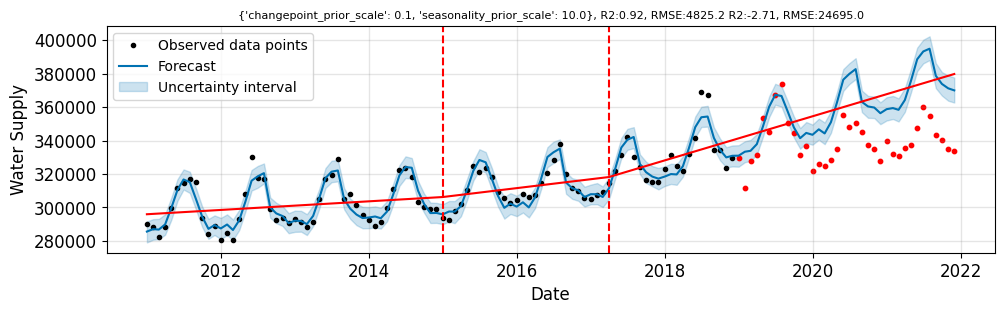

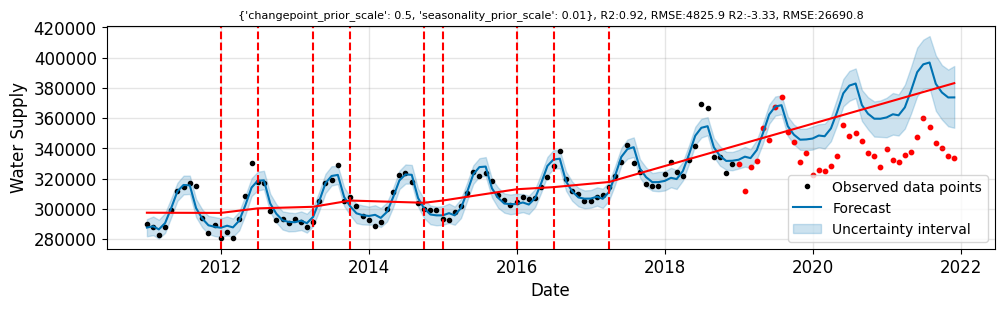

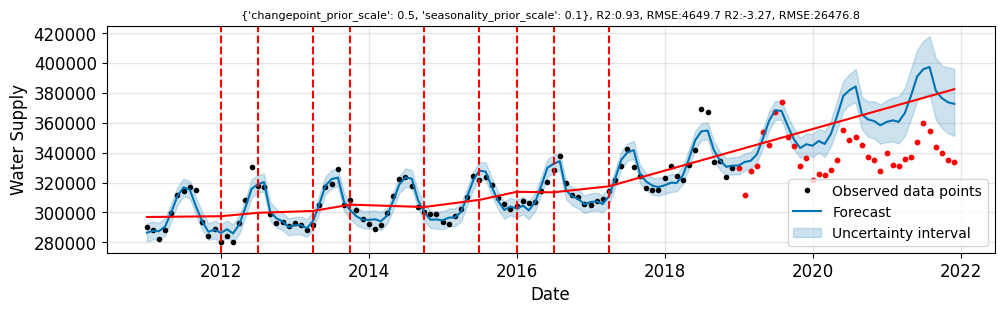

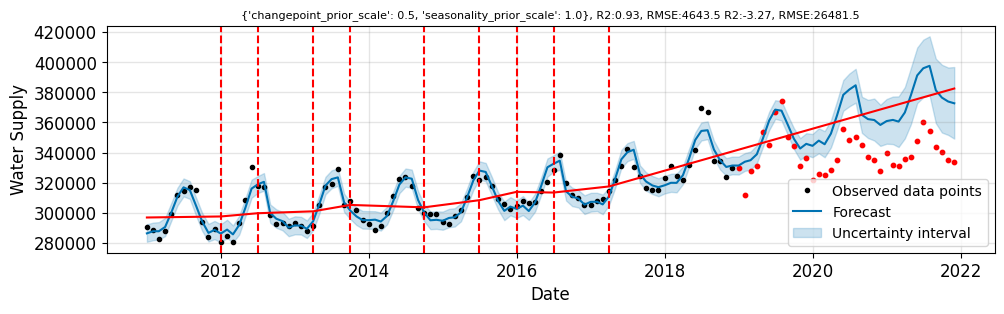

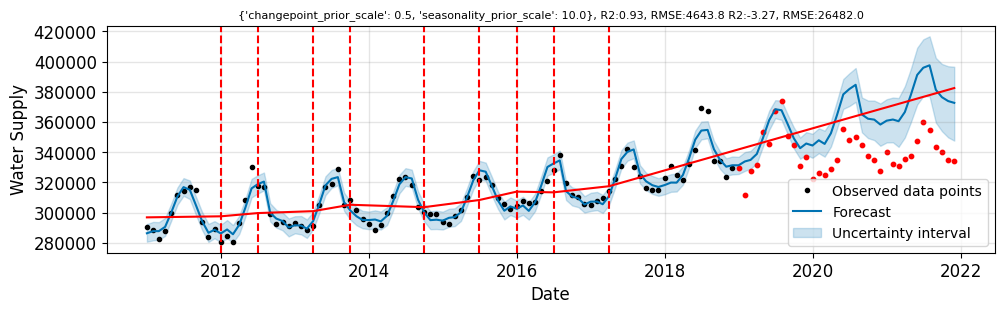

In [18]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAEs for each params here
r2s = [] 
rmses = [] 
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(seasonality_mode='additive', yearly_seasonality=10, **params)  # Fit model with given params

    m.fit(forecast_datasets)

    future = m.make_future_dataframe(periods=36, freq='MS')
    forecast = m.predict(future)
    
    mae = MAE(forecast['yhat'][-36:], analysis_datasets['y'][-36:])
    rmse = MSE(forecast['yhat'][-36:].values, analysis_datasets['y'][-36:].values, squared=False)
    r2 = R2(analysis_datasets['y'][-36:].values, forecast['yhat'][-36:].values)

    rmse_t = MSE(forecast['yhat'][:-36].values, analysis_datasets['y'][:-36].values, squared=False)
    r2_t = R2(analysis_datasets['y'][:-36].values, forecast['yhat'][:-36].values)

    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)

    fig = m.plot(forecast, figsize=(10, 3))
    a = add_changepoints_to_plot(fig.gca(), m, forecast)
    plt.scatter(analysis_datasets.index[-36:], analysis_datasets['y'][-36:], c="red", s=10)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Date', fontsize=12)  # Add an x-label to the axes.
    plt.ylabel('Water Supply', fontsize=12) 

    filename = f"Prophet Model Fitting for Water Demand Forecast({city_name}).png"
    #title = filename.split(".")[0]
    #newline = '\n'
    plt.title(f"{params}, R2:{r2_t:.2f}, RMSE:{rmse_t:.1f} R2:{r2:.2f}, RMSE:{rmse:.1f}", fontsize=8)
    plt.savefig(filename, bbox_inches='tight')
    plt.legend(fontsize=10)
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['r2'] = r2s
tuning_results['mae'] = maes
tuning_results['rmse'] = rmses
print(tuning_results)

In [19]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,r2,mae,rmse
0,0.001,0.01,0.584195,5996.219452,8266.349698
1,0.001,0.10,0.580522,6237.846497,8302.786586
2,0.001,1.00,0.580375,6095.829190,8304.238869
3,0.001,10.00,0.584704,6045.311988,8261.293069
4,0.010,0.01,0.018198,11308.833088,12702.262943
5,0.010,0.10,0.019350,11086.246187,12694.806805
6,0.010,1.00,0.046311,10881.418866,12519.081148
7,0.010,10.00,0.019699,11023.844653,12692.550785
8,0.100,0.01,-2.709595,21659.917191,24690.640045
9,0.100,0.10,-2.708161,21640.497126,24685.867042


10:42:08 - cmdstanpy - INFO - Chain [1] start processing


10:42:08 - cmdstanpy - INFO - Chain [1] done processing


   changepoint_prior_scale  seasonality_prior_scale        r2          mae  \
0                    0.001                     0.01  0.584195  5996.219452   

          rmse  
0  8266.349698  


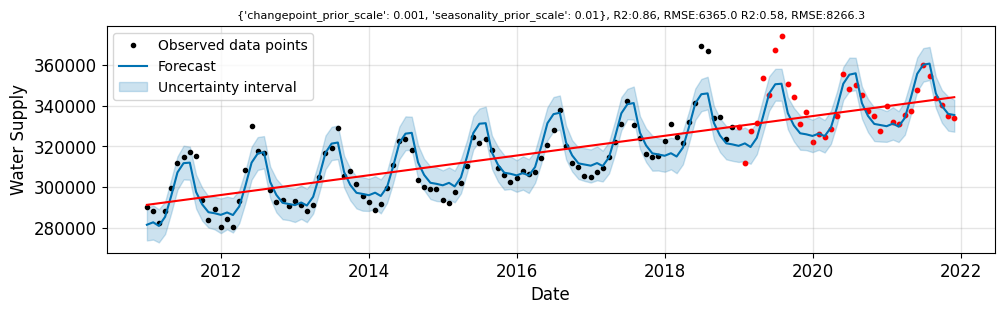

In [20]:
param_grid = {  
    'changepoint_prior_scale': [0.001],
    'seasonality_prior_scale': [0.01],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAEs for each params here
r2s = [] 
rmses = [] 
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(seasonality_mode='additive', yearly_seasonality=10, **params)  # Fit model with given params

    m.fit(forecast_datasets)

    future = m.make_future_dataframe(periods=36, freq='MS')
    forecast = m.predict(future)
    
    mae = MAE(forecast['yhat'][-36:], analysis_datasets['y'][-36:])
    rmse = MSE(forecast['yhat'][-36:].values, analysis_datasets['y'][-36:].values, squared=False)
    r2 = R2(analysis_datasets['y'][-36:].values, forecast['yhat'][-36:].values)

    rmse_t = MSE(forecast['yhat'][:-36].values, analysis_datasets['y'][:-36].values, squared=False)
    r2_t = R2(analysis_datasets['y'][:-36].values, forecast['yhat'][:-36].values)

    maes.append(mae)
    rmses.append(rmse)
    r2s.append(r2)

    fig = m.plot(forecast, figsize=(10, 3))
    a = add_changepoints_to_plot(fig.gca(), m, forecast)
    plt.scatter(analysis_datasets.index[-36:], analysis_datasets['y'][-36:], c="red", s=10)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Date', fontsize=12)  # Add an x-label to the axes.
    plt.ylabel('Water Supply', fontsize=12) 

    filename = f"Prophet Model Fitting for Water Demand Forecast({city_name}).png"
    #title = filename.split(".")[0]
    #newline = '\n'
    plt.title(f"{params}, R2:{r2_t:.2f}, RMSE:{rmse_t:.1f} R2:{r2:.2f}, RMSE:{rmse:.1f}", fontsize=8)
    plt.savefig(filename, bbox_inches='tight')
    plt.legend(fontsize=10)
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['r2'] = r2s
tuning_results['mae'] = maes
tuning_results['rmse'] = rmses
print(tuning_results)

In [21]:
forecast.to_csv(f"{city_name}_prophet.csv")

## Future Prediction to 2030 Years

10:58:16 - cmdstanpy - INFO - Chain [1] start processing
10:58:16 - cmdstanpy - INFO - Chain [1] done processing


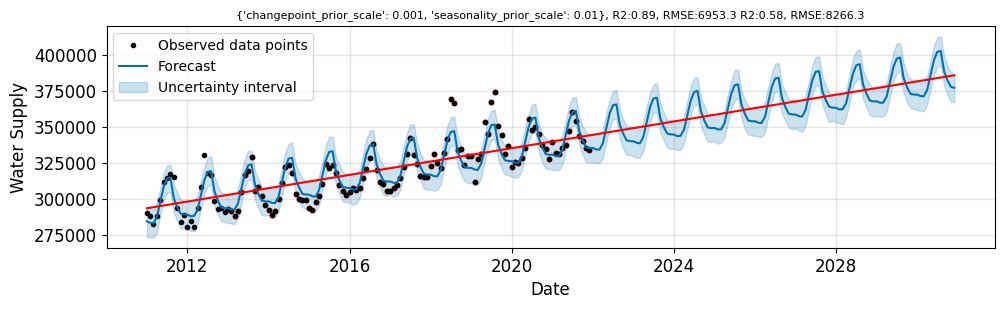

In [29]:
param_grid = {  
    'changepoint_prior_scale': [0.001],
    'seasonality_prior_scale': [0.01],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAEs for each params here
r2s = [] 
rmses = [] 
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(seasonality_mode='additive', yearly_seasonality=10, **params)  # Fit model with given params

    m.fit(analysis_datasets)

    future = m.make_future_dataframe(periods=108, freq='MS')
    forecast = m.predict(future)

    rmse_t = MSE(forecast['yhat'][:-108].values, analysis_datasets['y'][:].values, squared=False)
    r2_t = R2(analysis_datasets['y'][:].values, forecast['yhat'][:-108].values)

    fig = m.plot(forecast, figsize=(10, 3))
    a = add_changepoints_to_plot(fig.gca(), m, forecast)
    plt.scatter(analysis_datasets.index[-108:], analysis_datasets['y'][-108:], c="red", s=10)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Date', fontsize=12)  # Add an x-label to the axes.
    plt.ylabel('Water Supply', fontsize=12) 

    filename = f"Prophet Model Fitting for Water Demand Forecast({city_name}) Future.png"
    #title = filename.split(".")[0]
    #newline = '\n'
    plt.title(f"{params}, R2:{r2_t:.2f}, RMSE:{rmse_t:.1f} R2:{r2:.2f}, RMSE:{rmse:.1f}", fontsize=8)
    plt.savefig(filename, bbox_inches='tight')
    plt.legend(fontsize=10)

In [31]:
forecast.to_csv(f"{city_name}_prophet_future.csv")